# SUMMARY OF CHANGES FOR RESUBMISSION

- We tuned the parameters for the logistic regression model.
- Such tuning changed the final logistic regression model we recommended as well as some of the top features which we adjusted the verbiage accordingly.
- We corrected the section headings / notebook organization.
- We tuned the parameters for the support vector model.
- We used %%time instead of previous timing code.
- We added verbiage regarding SVM interpretation.

The changes are labeled as "UPDATED SECTION - " below.

# INTRODUCTION

In [1]:
# Read in data and packages
import pandas as pd
import numpy as np
#import bamboolib as bam
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score

df = pd.read_csv('ML1_data_adj_v2.csv')

The response variable for this classification analysis will be Fwd_Return_3M_Class, which represents the forward / future 3 month return of a given stock in our dataset relative to the 3 month return of the equal weighted S&P 500 index.  This captures whether a stock is deemed to have out- or under-performed during this time period.

In [2]:
# X variables = explanatory variables
X = df.drop(columns=['Date', 'ticker', 'Year', 'Fwd_ST_Accel_Class_3M', 'Fwd_Return_3M_Class', 'Fwd_Return_6M_Class', 'Fwd_Best_EPS_6M', 'Fwd_ST_Accel_3M','Sector','Fwd_Best_EPS_6M_v5Y', 'Fwd_Return_6M', 'Fwd_Return_3M', 'Fwd_Return_1M'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mkt_Cap                52663 non-null  float64
 1   Best_EPS_1M            52663 non-null  float64
 2   Best_EPS_3M            52663 non-null  float64
 3   Best_EPS_6M            52663 non-null  float64
 4   Best_EPS_1Y            52663 non-null  float64
 5   Best_EPS_3Y            52663 non-null  float64
 6   Best_EPS_5Y            52663 non-null  float64
 7   Best_EPS_3M_v5Y        52663 non-null  float64
 8   Best_EPS_6M_v5Y        52663 non-null  float64
 9   Best_EPS_1Y_v5Y        52663 non-null  float64
 10  Best_EPS_3Y_v5Y        52663 non-null  float64
 11  Best_EPS_3M_Rank       52663 non-null  float64
 12  Best_EPS_6M_Rank       52663 non-null  float64
 13  Best_EPS_1Y_Rank       52663 non-null  float64
 14  ST_Accel               52663 non-null  float64
 15  ST

In [3]:
# y = response variable
y = df[['Fwd_Return_3M_Class']]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [4]:
# We will use this object later on.
X_imputed = X

In [5]:
# Assess balance of data set
y.groupby(['Fwd_Return_3M_Class']).size().reset_index(name='counts')

,Fwd_Return_3M_Class,counts
0,0,23362
1,1,29301


# CREATE MODELS

## LOGISTIC REGRESSION MODELLING

As part of our logistic regression model building efforts, we built several models and sought to adjust parameters with the end goal in mind of improving accuracy, F1 score and AUC.  We built a model that included all of the variables and adjusted parameters to improve accuracy, then assessed the power of each of the variables (as detailed in forthcoming sections below).  With this information we then built two models based on feature importance weight thresholds of 0.1 and 0.3.  Then we built a dimension reduction model using PCA.

## UPDATED SECTION - MODEL 1

This model includes all explanatory variables

Model hyperparameter tuning summary:

• penalty - The norm of the penalty that we chose was "l1" as we found this selection in combination with the "liblinear" improved our accuracy, F1 and AUC scores by approximately 2%.

• dual - We kept dual=False through all iterations given n_samples > n_features.

• tol - We adjusted this parameter from the default of "0.001" down to "0.00001" as this added the run time by approximately 2 seconds and incrementally added to our performance measures by "0.001" thus we thought such adjustment was worth the cost / extra time.

• C - This parameter represents the inverse of regularization strength. We started with the default of 1 and adjusted the parameter both up and down.  We found that going up notably added to the running time of the model but did nothing to improve performance.  Lowering to 0.01 increased speed but did nothing to performance, while the value of 0.05 also aided speed and improved performance by ~1% so we went with this value.

• fit_intercept - This parameter specifies if a constant should be added to the decision function.  A value of True had the best performance so we went with this.

• intercept_scaling - This parameter is useful only when the solver ‘liblinear’ is used and self.fit_intercept is set to True. In this case, x becomes  a “synthetic” feature with constant value equal to intercept_scaling is appended to the instance vector.  Given we used 'liblinear' and intercept at True, we attempted to tune this parameter but upon trying higher and lower values than the default of 1, we found such default to result in best performance.

• class_weight - Upon running initial models we found that the prediction classes was imbalanced.  As such, we chose the "balanced" option for this parameter which evened out the output accordingly.

• random_state  This parameter is used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.  Given we used 'liblinear' we utilized this parameter.

• solver - As previously discussed with the penalty parameter, we found 'liblinear' to aid performance the most.

• max_iter - Adjusting the parameter did nothing to alter performance thus we left it at the default of 100.

• multi_class - Given we used the 'liblinear' solver, this parameter was set to 'auto' which in turn selects 'ovr' thus we left the default in place.

• verbose - Nothing changed in performance after adjusting this parameter thus we left it at the default of 0.

• warm_start - Useless for 'liblinear' solver so we did not adjust.

• n_jobs - Parameter is ignored with 'liblinear' solver.

• l1_ratio - Only used for 'elasticnet' penalty so ignored.


In [6]:
# MODEL 1

# Import needed packages
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Test train split 
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
# Check balance of dependent variables
y_train.groupby(['Fwd_Return_3M_Class']).size().reset_index(name='counts')

,Fwd_Return_3M_Class,counts
0,0,18747
1,1,23383


In [8]:
y_test.groupby(['Fwd_Return_3M_Class']).size().reset_index(name='counts')

,Fwd_Return_3M_Class,counts
0,0,4615
1,1,5918


In [9]:
# Normalize / scale variables
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

In [10]:
# train the model 

# Model 1 - with hyperparemeter tuning as detailed above
lr_clf = LogisticRegression(penalty='l1', dual=False, tol=0.00001, C=0.05, fit_intercept=True, intercept_scaling=1, 
                            class_weight="balanced", random_state = 123, solver='liblinear', max_iter=100,
                           multi_class='auto', verbose=0) 

In [11]:
%%time

# Train object
lr_clf.fit(X_train_scaled,y_train.values.ravel())  

# Get test set predictions
y_hat = lr_clf.predict(X_test_scaled) 

# Accuracy
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y_test, y_hat)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y_test, y_hat)
print('AUC:', auc )

accuracy: 0.5510300958891104
[[2572 2043]
 [2686 3232]]
F1 score: 0.5775037970159922
AUC: 0.5517217794509799
Wall time: 4.01 s


## MODEL 2 & 3

Alternate logistic regression models using feature reduction.

Model 2 uses the tuned Model 1 and then adjusts features based on importance weights for explanatory variables >= 0.1.

Model 3 uses the tuned Model 1 and then adjusts features based on importance weights for explanatory variables >= 0.3.

Although Model 2 reduces the amount of explanatory variables and to those with higher weights and incrementally improves the speed of the model calculation, there is a slight reduction to accuracy.  And given the speed differential is minimal, we chose Model 1 as our final logistic regression model.

In [12]:
#MODEL 2
#explanatory variables for feature reduction model
# Selected by weights greater than .1
X2 = df[['An_Down_6M','Best_EPS_6M_Rank', 'Best_EPS_1Y_Rank', 'An_Mark_6M','An_Unch_6M','An_Unch','NRR',
        'An_Mark','An_Down','Best_EPS_5Y_R2_Rank','Best_EPS_3Y_R2','Best_EPS_Mean_Med','Best_EPS_Hi_Lo','Best_EPS_Sigma_1Y',
        'ROIC']]

X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   An_Down_6M           52663 non-null  float64
 1   Best_EPS_6M_Rank     52663 non-null  float64
 2   Best_EPS_1Y_Rank     52663 non-null  float64
 3   An_Mark_6M           52663 non-null  float64
 4   An_Unch_6M           52663 non-null  float64
 5   An_Unch              52663 non-null  float64
 6   NRR                  52663 non-null  float64
 7   An_Mark              52663 non-null  float64
 8   An_Down              52663 non-null  float64
 9   Best_EPS_5Y_R2_Rank  52663 non-null  float64
 10  Best_EPS_3Y_R2       52663 non-null  float64
 11  Best_EPS_Mean_Med    52663 non-null  float64
 12  Best_EPS_Hi_Lo       52663 non-null  float64
 13  Best_EPS_Sigma_1Y    52663 non-null  float64
 14  ROIC                 52663 non-null  float64
dtypes: float64(15)
memory usage: 6.0 MB


In [13]:
# y = response variable
y2 = df[['Fwd_Return_3M_Class']]
y2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [14]:
# Logistical Regression Object
lr_clf2 = LogisticRegression(penalty='l1', dual=False, tol=0.00001, C=0.05, fit_intercept=True, intercept_scaling=1, 
                            class_weight="balanced", random_state = 123, solver='liblinear', max_iter=100,
                           multi_class='auto', verbose=0)

In [15]:
# Test train split 
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [16]:
# scale attributes by the training set
scl_obj2 = StandardScaler()
scl_obj2.fit(X2_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled2 = scl_obj2.transform(X2_train) # apply to training
X_test_scaled2 = scl_obj2.transform(X2_test) # apply those means and std to the test set (without snooping at the test set values)

In [17]:
%%time

# Train object
lr_clf2.fit(X_train_scaled2,y2_train.values.ravel())  

# Get test set predictions
y_hat2 = lr_clf2.predict(X_test_scaled2) 

# Accuracy
acc = mt.accuracy_score(y2_test,y_hat2)
conf = mt.confusion_matrix(y2_test,y_hat2)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y2_test, y_hat2)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y2_test, y_hat2)
print('AUC:', auc )

accuracy: 0.5421057628405962
[[2499 2116]
 [2707 3211]]
F1 score: 0.5710982658959538
AUC: 0.5420385389781692
Wall time: 205 ms


In [18]:
#MODEL 3
#explanatory variables for feature reduction model
# Selected by weights greater than .3
X3 = df[['An_Down_6M', 'Best_EPS_1Y_Rank', 'An_Mark_6M',
        'An_Mark','An_Down','Best_EPS_5Y_R2_Rank','Best_EPS_3Y_R2','Best_EPS_Mean_Med','Best_EPS_Hi_Lo','Best_EPS_Sigma_1Y',
        'ROIC']]

X3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   An_Down_6M           52663 non-null  float64
 1   Best_EPS_1Y_Rank     52663 non-null  float64
 2   An_Mark_6M           52663 non-null  float64
 3   An_Mark              52663 non-null  float64
 4   An_Down              52663 non-null  float64
 5   Best_EPS_5Y_R2_Rank  52663 non-null  float64
 6   Best_EPS_3Y_R2       52663 non-null  float64
 7   Best_EPS_Mean_Med    52663 non-null  float64
 8   Best_EPS_Hi_Lo       52663 non-null  float64
 9   Best_EPS_Sigma_1Y    52663 non-null  float64
 10  ROIC                 52663 non-null  float64
dtypes: float64(11)
memory usage: 4.4 MB


In [19]:
# y = response variable
y3 = df[['Fwd_Return_3M_Class']]
y3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [20]:
# Logistical Regression Object
lr_clf3 = LogisticRegression(penalty='l1', dual=False, tol=0.00001, C=0.05, fit_intercept=True, intercept_scaling=1, 
                            class_weight="balanced", random_state = 123, solver='liblinear', max_iter=100,
                           multi_class='auto', verbose=0)

In [21]:
# Test train split 
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)

In [22]:
# scale attributes by the training set
scl_obj3 = StandardScaler()
scl_obj3.fit(X3_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled3 = scl_obj3.transform(X3_train) # apply to training
X_test_scaled3 = scl_obj3.transform(X3_test) # apply those means and std to the test set (without snooping at the test set values)

In [23]:
%%time

# Train object
lr_clf3.fit(X_train_scaled3,y3_train.values.ravel())  

# Get test set predictions
y_hat3 = lr_clf3.predict(X_test_scaled3) 

# Accuracy
acc = mt.accuracy_score(y3_test,y_hat3)
conf = mt.confusion_matrix(y3_test,y_hat3)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y3_test, y_hat3)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y3_test, y_hat3)
print('AUC:', auc )

accuracy: 0.5340358872116207
[[2441 2174]
 [2734 3184]]
F1 score: 0.564739269244413
AUC: 0.5334735059170894
Wall time: 109 ms


## MODEL 4

Model 4 uses dimension reduction / PCA to build the explanatory variables.  Upon running our PCA analysis, we chose to use 10 principle components in our model based on the results of the scree plot which should this amount captured nearly 100% of the total variance.


Eigenvalues:
[4.17998999e+00 2.32216808e+00 2.00281699e+00 1.84349987e+00
 1.07838281e+00 9.62395946e-01 9.19740332e-01 6.02294977e-01
 5.02452108e-01 3.30426015e-01 2.39824046e-01 7.51204665e-03
 5.96588549e-03 1.85253578e-03 9.63204410e-04]

Variances (Percentage):
[2.78660708e+01 1.54808266e+01 1.33518597e+01 1.22897658e+01
 7.18908222e+00 6.41585114e+00 6.13148578e+00 4.01522360e+00
 3.34961711e+00 2.20279827e+00 1.59879661e+00 5.00793601e-02
 3.97718147e-02 1.23500040e-02 6.42124080e-03]



Text(0, 0.5, 'Explained variance (%)')

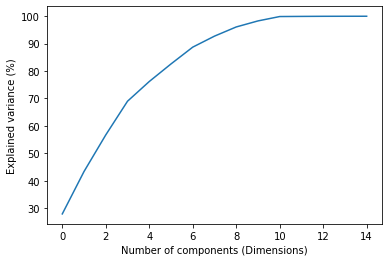

In [24]:
from matplotlib import pyplot

# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X2)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
pyplot.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
pyplot.xlabel("Number of components (Dimensions)")
pyplot.ylabel("Explained variance (%)")

In [25]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X2)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
print(X_pca.head())
print("\nSize: ")
print(X_pca.shape)

          0         1         2         3         4         5         6  \
0 -0.268409  1.273752 -1.008550 -0.071486 -1.297822  1.137634  0.003183   
1  4.393952 -1.949254 -0.755515 -0.172601  3.400657  0.310062  1.713363   
2 -0.694271  1.550715  1.047877  1.099140  0.513444 -0.418342 -1.015187   
3  0.993207 -1.655574 -0.745595 -0.597915  0.352893  0.365016 -0.318081   
4 -1.570718 -0.914930  1.250978 -0.131635  0.319105 -0.043232 -0.357801   

          7         8         9  
0  1.896500 -0.399462 -1.315777  
1  0.048878 -1.276809  2.009399  
2  0.480146  0.980311 -0.987108  
3  1.750193 -0.038827 -0.389318  
4 -0.956501 -0.625114  0.598352  

Size: 
(52663, 10)


In [26]:
# y = response variable
y4 = df[['Fwd_Return_3M_Class']]
y4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [27]:
# Logistical Regression Object
lr_clf4 = LogisticRegression(penalty='l1', dual=False, tol=0.00001, C=0.05, fit_intercept=True, intercept_scaling=1, 
                            class_weight="balanced", random_state = 123, solver='liblinear', max_iter=100,
                           multi_class='auto', verbose=0)

In [28]:
# Test train split 
X4_train_pca, X4_test_pca, y4_train, y4_test = train_test_split(X_pca, y4, test_size=0.2, random_state=123)

In [29]:
%%time

# Train object
lr_clf4.fit(X4_train_pca,y4_train.values.ravel())  

# Get test set predictions
y_hat4 = lr_clf4.predict(X4_test_pca) 

# Accuracy
acc = mt.accuracy_score(y4_test,y_hat4)
conf = mt.confusion_matrix(y4_test,y_hat4)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y4_test, y_hat4)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y4_test, y_hat4)
print('AUC:', auc )

accuracy: 0.5386879331624419
[[2513 2102]
 [2757 3161]]
F1 score: 0.5654234862713532
AUC: 0.5393309319090773
Wall time: 42.6 ms


### UPDATED SECTION - Logistic regression final

As detailed above, after assessing our four models we decided to go with Model 1 which included all the explanatory variables. Thus the added performance (even if incremental) is deemed worth the few seconds longer it takes to run the model . 

In [30]:
# Accuracy
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y_test, y_hat)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y_test, y_hat)
print('AUC:', auc )

accuracy: 0.5510300958891104
[[2572 2043]
 [2686 3232]]
F1 score: 0.5775037970159922
AUC: 0.5517217794509799


# SUPPORT VECTOR MACHINES MODELLING

In [31]:
X_svm = X.values
y_svm = y.values

In [32]:
# Normalize / scale variables
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj5 = StandardScaler()
scl_obj5.fit(X_svm) # find scalings for each column that make this zero mean and unit std

X_scaled = scl_obj5.transform(X_svm) # apply to training

In [37]:
# Import library
from sklearn.svm import SVC

# Train the model
svm_clf = SVC() 

# Cross validation object
from sklearn.model_selection import ShuffleSplit

num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2, random_state=123)
                         
print(cv_object)

ShuffleSplit(n_splits=1, random_state=123, test_size=0.2, train_size=None)


In [38]:
%%time

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X_scaled,y): 
    X_train = X_scaled[train_indices]
    y_train = y_svm[train_indices]
    
    X_test = X_scaled[test_indices]
    y_test = y_svm[test_indices]
    
    svm_clf.fit(X_train,y_train.ravel())  # train object
    y_hat = svm_clf.predict(X_test) # get test set predictions

    # accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    
    #calculate F1 score
    f1 = f1_score(y_test, y_hat)
    print('F1 score:', f1 )
    
    #calculate AUC
    auc = roc_auc_score(y_test, y_hat)
    print('AUC:', auc )
    
    iter_num+=1


====Iteration 0  ====
accuracy 0.7251495300484192
confusion matrix
 [[2522 2093]
 [ 802 5116]]
F1 score: 0.779462177192047
AUC: 0.7054800584514181
Wall time: 3min 23s


# UPDATED SECTION - Here are the parameter adjustments to the SVM model above: 
- Instead of only using the "balanced" option for the class_weight parameter, I will also use Stratified ShuffleSplit; This is a cross-validator that provides train/test indices to split data in train/test sets. The cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. These folds are made by preserving the percentage of samples for each class. The reason for using Stratified ShuffleSplit instead of ShuffleSplit is in order to train the SVM model on more balanced class sets, which might lead to an increase in performance. However, because stratified random splits do not guarantee that all folds will be different- but this is unlikely for a sizeable data set. The point in using both the class_weight = "balanced" parameter and a Stratified ShuffleSplit is to optimize the class balance in our data set.
- I am also going to increase the train size to 90% of the length of the data set. I am doing this in an effort to maximize the amount of data the model has to train to increase the accuracy- albeit, this effort might only lead to a miniscule increase in our chosen metrics.
- I am also going to compare these changes with a linear SVM classifier with stochastic gradient descent, which will give us the gradient of the loss with each estimated sample at a time, updating the model with the learning rate. 
- C - I adjusted the regularization parameter both up and down from the default of 1 and found lowering the value (down to 0.05) hurt performance significantly, while raising the value (up to 2) was additive thus we chose to go with 2.
- kernel - I tested the various kernel options and found 'rbf' to be the best for performance so that was chosen.
- gamma - I tested the kernel coefficient and found auto to produce the best performance results so that was chosen.
- coef0 - This parameter was skipped since 'rbf' was used.
- tol - This parameter represents the tolerance for stopping criterion and the default is 0.001.  I tested numbers up to 1 and found to be relatively a wash as the higher number aided accuracy but lowered the F1 and AUC all of which was only by hundreds of a tenth of a percent so we chose the default of 0.001.

#### I also added/clarified the Support Vector Insight section to include the "Stratified ShuffleSplit, non-linear SVM" model and the "Linear SVM with SGD" model. 

In [49]:
# Stratified ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
svm_clf = SVC(C = 2, kernel ='rbf', gamma='auto', class_weight='balanced', tol=0.001) 
num_cv_iterations = 1
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits = num_cv_iterations, test_size  = 0.1, random_state=123)
print(cv_object)


StratifiedShuffleSplit(n_splits=1, random_state=123, test_size=0.1,
            train_size=None)


In [50]:
%%time

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X_scaled,y): 
    X_train = X_scaled[train_indices]
    y_train = y_svm[train_indices]
    
    X_test = X_scaled[test_indices]
    y_test = y_svm[test_indices]
    
    svm_clf.fit(X_train,y_train.ravel())  # train object
    y_hat = svm_clf.predict(X_test) # get test set predictions

    # accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    
    #calculate F1 score
    f1 = f1_score(y_test, y_hat)
    print('F1 score:', f1 )
    
    #calculate AUC
    auc = roc_auc_score(y_test, y_hat)
    print('AUC:', auc )
    
    iter_num+=1

====Iteration 0  ====
accuracy 0.7748243782039111
confusion matrix
 [[1745  592]
 [ 594 2336]]
F1 score: 0.7975418231478321
AUC: 0.7719767036003394
Wall time: 6min 7s


In [51]:
# Linear SVM with SGD Learning
# Using the same Stratified ShuffleSplit object from above
from sklearn.linear_model import SGDClassifier

num_cv_iterations = 1
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits = num_cv_iterations, test_size  = 0.1, random_state=123)
print(cv_object)
svm_sgd = SGDClassifier(alpha = 0.01, fit_intercept = True, 
                       l1_ratio = 0.0, learning_rate = 'optimal',
                       loss = 'hinge', n_iter_no_change = 5, 
                       n_jobs = -1, penalty = 'l2')



StratifiedShuffleSplit(n_splits=1, random_state=123, test_size=0.1,
            train_size=None)


In [52]:
%%time 
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X_scaled,y): 
    X_train = X_scaled[train_indices]
    y_train = y_svm[train_indices]
    
    X_test = X_scaled[test_indices]
    y_test = y_svm[test_indices]
    
    svm_sgd.fit(X_train,y_train.ravel())  # train object
    y_hat = svm_clf.predict(X_test) # get test set predictions

    # accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    
    #calculate F1 score
    f1 = f1_score(y_test, y_hat)
    print('F1 score:', f1 )
    
    #calculate AUC
    auc = roc_auc_score(y_test, y_hat)
    print('AUC:', auc )
    
    iter_num+=1


====Iteration 0  ====
accuracy 0.7748243782039111
confusion matrix
 [[1745  592]
 [ 594 2336]]
F1 score: 0.7975418231478321
AUC: 0.7719767036003394
Wall time: 11.1 s


### UPDATED SECTION - 
Findings after hyperparameter tuning and model comparison: 

It seems that each hyperparameter tuned in each subsequent SVM model seemed to slightly boost performance in terms of accuracy, F1 score, and AUC. Further model hyperparameter tuning would be advanced by finding the optimal cost function; however, we believe that a gradient based alternative would be better suited for scaling the model should we include more features- should the case arise. 

The Linear SVM with SGD Learning was deemed the best model as it had comparable performance as the tuned SVC but was much faster (6 min vs 11 seconds).

# MODEL ADVANTAGES - COMPARING MODELS

Detailed below are the finalized results for our logistic regression (LR) and support vector (SVM) models based on pertinent stats:

Accuracy:  LR = 55.1% vs SVM = 77.5%

F1 Score:  LR = 57.8% vs SVM = 79.8%

AUC:  LR = 55.2% vs SVM = 77.2%

Training time:  LR = 3.94 seconds vs SVM = 11.1 seconds

Upon comparing the outputs of our models, we support the choice of the SVM as our recommended model from this analysis.  As you can see above, the performance (Accuracy, F1 score (which captures precision and recall) and Area Under the Curve (AUC)) are superior for the SVM relative to the LR model.  With this better performance comes at only a few seconds longer in training time.

In the highly competitive industry of investment management, the ability to outperform the market is extremely difficult.  The target use case for our project analyses (including this lab) is an investment manager that is picking stocks that will outperform and avoiding those that will underperform (i.e. long-only styled strategies).  Thus on the one hand, one could see the results of this analysis in a modestly positive light given we had accuracies nearly 80% which in the investment management industry is favorable / would outperform the market.  On the other hand, we remain optimistic that we can improve upon such results and are looking forward to digging deeper into different classification techniques / algorithms in hopes that we can further improve the outputs and prediction capabilities with our dataset during forthcoming modelling analyses.

# UPDATED SECTION - INTERPRET LOGISTIC REGRESSION FEATURE IMPORTANCE

Upon completion of building and finalizing our logistic modelling efforts, we then sought to explore which features showed the most efficacy on our chosen model.  

The top 5 variables based on absolute values with their respective coefficient are as follows (in order from highest to lowest):

Best_EPS_1Y_Rank has weight of -0.16163764183821985

An_Down_6M has weight of 0.14968924221077506

An_Down has weight of -0.134536882180097

Best_EPS_3Y_R2 has weight of 0.12247478513828015

FCF_Mgn has weight of 0.11565699518846338


Refresher on the definition of each of these variables:

An_Down - This represents the percentage during the past 3 month period of total revisions by the sell side analysts covering a given stock which were negative.

An_Down_6M - This variable seeks to capture the second derivative changes of "An_Down" and is calculated by subtracting the "An_Down" value 6 months ago from the current value.  This helps to determine the overall trend in such negative revisions during this time period.

Best_EPS_1Y_Rank - This represents the rank of a stock in this universe based on the past 1 year growth rate of their median consensus EPS.

Best_EPS_3Y_R2 - This metric calculates the R2 on a 3 year basis between EPS and time.

FCF_Mgn - This represents the trailing 1Y free cash flow margin of the stock.  

The three variables of Best_EPS_1Y_Rank, Best_EPS_3Y_R2 and FCF_Mgn seem to be intuitive with their predictability based on the following:

Based on the concept of momentum (which is the basis of our EPS Estimate Revision momentum modelling efforts detailed in the prior lab and serves as the same data used in this lab), we were not surprised to see Best_EPS_1Y_Rank showing efficacy and a positive relationship with predicting whether a stock will outperform or not during the next 3 months.  It appears that a 1 year trend is more powerful in it's predictability than both shorter and longer term calculations thus may be a sweet spot of not being too short of a time period which can capture noise in the data and too long term which is not able to capture changes in trend.  Also confirming our thoughts on the subject of the power of stability measures such as R2 which are also positively correlated, as well as free cash flow margin which is evidence of the underlying strength of fundamentals.

The most complex yet interesting variables were the top two which were An_Down and An_Down_6M which showed positive and negative relationships with the response variable, respectively.  The overall theory we have for this result is based on the emotions of the stock market whereby negative sentiment towards a stock can be extrapolated incorrectly especially in the short term.  To best explain what may be going on with these variables we will provide an example.  Let's assume XYZ stock has a An_Down value of 100 which means that 100% of the analysts have revised their estimates down during the past 3 months.  As such, this is deemed to be negative for the stock price during the next 3 months per our model.  At this same time, let's assume the An_Down_6M value is also 100 which means that the An_Down value 6 months ago was 0 and implies that the negative revisions have taken place in recent months (i.e. this negative trend has not been in place for greater than 6 months).  This implies that the sentiment towards EPS has turned down from where it was more recently.  So how can this be a potential positive for the stock price in the next 3 months?  This goes back to our extrapolation theory that when analysts get too negative too fast in the short term they may have become extrapolated incorrectly and become too pessimistic (and vice versa) in their estimates which the market will self correct by mean reverting the stock during the next 3 months.  

In [53]:
# List out attributes with coefficients for Model 1
zip_vars = zip(lr_clf.coef_.T,X.columns) 
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

Mkt_Cap has weight of 0.06103740750025913
Best_EPS_1M has weight of 0.019647185449629036
Best_EPS_3M has weight of 0.057368427211552574
Best_EPS_6M has weight of -0.07452111488174266
Best_EPS_1Y has weight of 0.00354736703105763
Best_EPS_3Y has weight of -0.007794109237356608
Best_EPS_5Y has weight of 0.04128755769323904
Best_EPS_3M_v5Y has weight of -0.023398986531238435
Best_EPS_6M_v5Y has weight of 0.0
Best_EPS_1Y_v5Y has weight of 0.07142451831577892
Best_EPS_3Y_v5Y has weight of 0.028557241505640738
Best_EPS_3M_Rank has weight of 0.05096813512985673
Best_EPS_6M_Rank has weight of 0.11699402193371204
Best_EPS_1Y_Rank has weight of -0.16163764183821985
ST_Accel has weight of 0.0
ST_Accel_Class has weight of -0.04656526290490276
NRR_6M has weight of 0.0
An_Mark_6M has weight of 0.0
An_Unch_6M has weight of 0.04883298324627607
An_Down_6M has weight of 0.14968924221077506
An_Up_6M has weight of 0.0
NRR_3M has weight of 0.0
An_Mark_3M has weight of 0.0
An_Unch_3M has weight of 0.0
An_Do

In [54]:
# List out attributes by numeric identifier to ease interpretation

# get importance
importance = lr_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.06104
Feature: 1, Score: 0.01965
Feature: 2, Score: 0.05737
Feature: 3, Score: -0.07452
Feature: 4, Score: 0.00355
Feature: 5, Score: -0.00779
Feature: 6, Score: 0.04129
Feature: 7, Score: -0.02340
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.07142
Feature: 10, Score: 0.02856
Feature: 11, Score: 0.05097
Feature: 12, Score: 0.11699
Feature: 13, Score: -0.16164
Feature: 14, Score: 0.00000
Feature: 15, Score: -0.04657
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.04883
Feature: 19, Score: 0.14969
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.08649
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.04281
Feature: 29, Score: -0.13454
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00114
Feature: 32, Score: 0.01258
Feature: 33, Score: -0.05879
Feature: 34, Score: -0.03204
Feature: 35, Score: 0.

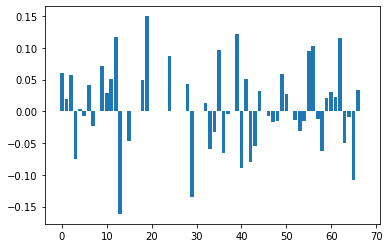

In [55]:
from matplotlib import pyplot

# plot feature importance by numeric identifier to ease interpretation
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [56]:
# helps to see which numbers align with which variable
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mkt_Cap                52663 non-null  float64
 1   Best_EPS_1M            52663 non-null  float64
 2   Best_EPS_3M            52663 non-null  float64
 3   Best_EPS_6M            52663 non-null  float64
 4   Best_EPS_1Y            52663 non-null  float64
 5   Best_EPS_3Y            52663 non-null  float64
 6   Best_EPS_5Y            52663 non-null  float64
 7   Best_EPS_3M_v5Y        52663 non-null  float64
 8   Best_EPS_6M_v5Y        52663 non-null  float64
 9   Best_EPS_1Y_v5Y        52663 non-null  float64
 10  Best_EPS_3Y_v5Y        52663 non-null  float64
 11  Best_EPS_3M_Rank       52663 non-null  float64
 12  Best_EPS_6M_Rank       52663 non-null  float64
 13  Best_EPS_1Y_Rank       52663 non-null  float64
 14  ST_Accel               52663 non-null  float64
 15  ST

# UPDATED SECTION - INTERPRET SUPPORT VECTORS

In [57]:
# quick look at the support vectors of the Stratified ShuffleSplit, non-linear SVM 
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(35047, 68)
(35047,)
[15640 19407]


As we can see in the cell above, the support vectors are the data points that are close to the hyperplane that influence the position and orientation of the hyperplane; these support vectors maximize the margin of the classifier. These were taken from the model with the highest accuracy, found in the code results above.

In [58]:
# if using linear kernel, these make sense to look at (not otherwise)
# We left this in just to show that it will not work since we used radial basis function for our svm_clf model
# as our kernel
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_imputed.columns)
weights.plot(kind='bar')

AttributeError: coef_ is only available when using a linear kernel

[[ 0.01163922  0.01695972  0.03114569 -0.06011174  0.00217282 -0.01851293
   0.02025831 -0.01447097  0.02056132  0.02583814  0.01553226  0.01959611
   0.03880761 -0.04908569  0.00381745 -0.02126986 -0.014042   -0.01005255
   0.03656714  0.05293073  0.02383982 -0.00629764  0.02821757 -0.01819105
   0.00637506 -0.00481998  0.02121992  0.01420762  0.01934044 -0.04863452
  -0.00642937  0.01449229  0.00980713 -0.02332591 -0.03553812  0.02454915
  -0.0307178  -0.00305361  0.0190831   0.10277248 -0.08469203  0.042976
  -0.03993484 -0.05004234  0.04830163 -0.02596765  0.01273959 -0.00330761
  -0.01764563  0.04308726  0.02254593 -0.00203476 -0.00137082 -0.00572969
  -0.01593018  0.08435501  0.02996757 -0.00248679 -0.07886192  0.00018286
   0.03894917  0.01359702  0.06601851 -0.02824193 -0.05272012 -0.04510932
   0.01982145  0.00735677]]


<AxesSubplot:>

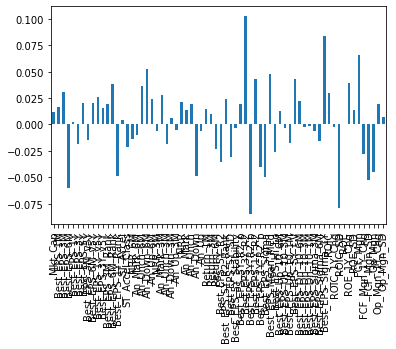

In [59]:
# Since we did use a Linear SVM with Stochastic Gradient Descent, we can analyze the coefficients for the model
print(svm_sgd.coef_)
weights = pd.Series(svm_sgd.coef_[0],index=X_imputed.columns)
weights.plot(kind='bar')

In [60]:
# Here are the variables from the Linear SVM with SGD based on absolute values with their 
# respective coefficients (in order from highest to lowest):
zip_vars = sorted(zip(svm_sgd.coef_.T,X.columns))
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

Best_EPS_3Y_R2_p has weight of -0.0846920279550045
ROIC_SD has weight of -0.0788619196256023
Best_EPS_6M has weight of -0.06011174448151654
FCF_Mgn_SD has weight of -0.05272011583598896
Best_EPS_Sigma has weight of -0.050042335393560095
Best_EPS_1Y_Rank has weight of -0.0490856898487906
An_Down has weight of -0.04863452223594436
Op_Mgn has weight of -0.04510932122671197
Best_EPS_1Y_R2_p has weight of -0.039934836490450175
Best_EPS_5Y_R2 has weight of -0.03553811586685531
Best_EPS_5Y_SD has weight of -0.03071779716431041
FCF_Mgn_1Y_Chg has weight of -0.028241933606571058
Best_EPS_Hi_Lo has weight of -0.025967649794183117
Return_6M has weight of -0.023325914833183407
ST_Accel_Class has weight of -0.02126985504592834
Best_EPS_3Y has weight of -0.018512932157061564
An_Unch_3M has weight of -0.018191048648208554
Best_EPS_Up_10_1M has weight of -0.017645634617929003
Best_EPS_Sigma_6M has weight of -0.015930184853123582
Best_EPS_3M_v5Y has weight of -0.014470973295664467
NRR_6M has weight of 

In [61]:
print("Attributes of the Linear SVM with SGD Model: ")
print("\n")
print("Actual number of iterations: {}".format(svm_sgd.n_iter_))
print('\n')
print("Classes: {}".format(svm_sgd.classes_))
print('\n')
print("Number of weight updates performed during training: {}".format(svm_sgd.t_))
print('\n')
print("Number of features seen during .fit: {}".format(svm_sgd.n_features_in_))

Attributes of the Linear SVM with SGD Model: 


Actual number of iterations: 13


Classes: [0 1]


Number of weight updates performed during training: 616149.0


Number of features seen during .fit: 68


The below cell shows the instances that were chosen as the support vectors. It also might indicate if they are indicative of anything, following our intuition. First, we made a dataframe of the training data, then appended the support vectors from the training model, with the original response variable from the original data. 

In [62]:
df_tested_on = X_imputed.iloc[train_indices].copy()
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['Fwd_Return_3M_Class'] = y_svm[svm_clf.support_]
X_imputed['Fwd_Return_3M_Class'] = y_svm

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35047 entries, 44763 to 19395
Data columns (total 69 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mkt_Cap                35047 non-null  float64
 1   Best_EPS_1M            35047 non-null  float64
 2   Best_EPS_3M            35047 non-null  float64
 3   Best_EPS_6M            35047 non-null  float64
 4   Best_EPS_1Y            35047 non-null  float64
 5   Best_EPS_3Y            35047 non-null  float64
 6   Best_EPS_5Y            35047 non-null  float64
 7   Best_EPS_3M_v5Y        35047 non-null  float64
 8   Best_EPS_6M_v5Y        35047 non-null  float64
 9   Best_EPS_1Y_v5Y        35047 non-null  float64
 10  Best_EPS_3Y_v5Y        35047 non-null  float64
 11  Best_EPS_3M_Rank       35047 non-null  float64
 12  Best_EPS_6M_Rank       35047 non-null  float64
 13  Best_EPS_1Y_Rank       35047 non-null  float64
 14  ST_Accel               35047 non-null  float64
 15

In [63]:
print("Attributes of the Stratified ShuffleSplit, non-linear SVM")
print('\n')
print("Class weights: {}".format(svm_clf.class_weight_))
print('\n')
print("Classes: {}".format(svm_clf.classes_))
print('\n')
print("Constants in the decision function: {}".format(svm_clf.intercept_))
print('\n')
print("The number of feature seen during the fit: {}".format(svm_clf.n_features_in_))
print('\n')
print("The indices of support vectors: {}".format(svm_clf.support_))
print('\n')
print("The number of support vectors for each class: {}".format(svm_clf.n_support_))
print('\n')
print("The array of dimensions of training vector X: {}".format(svm_clf.shape_fit_))

Attributes of the Stratified ShuffleSplit, non-linear SVM


Class weights: [1.12713436 0.89863866]


Classes: [0 1]


Constants in the decision function: [-0.0321947]


The number of feature seen during the fit: 68


The indices of support vectors: [    0     2     6 ... 47391 47392 47394]


The number of support vectors for each class: [15640 19407]


The array of dimensions of training vector X: (47396, 68)


### UPDATED SECTION - Insights from the Stratified ShuffleSplit, non-linear SVM Model and the Linear SVM with SGD Model

Below, we have produced a Kernel Density Estimation (KDE) for a selection of variables, which allows us to view the probability density function of the variables. By utilizing KDE, we are not assuming that there is an underlying distribution with the data, which means that we are not fitting by a mean or standard deviation. We noticed that the plots constructed from the Logistic Regression model and the Support Vector model are very similar and close in distribution, with subtle differences that we will note below.

FCF_Mgn: The historical 12-month free cash flow margin. One aspect to notice is that compared to that of the LR model, the density estimates for the blue (lose) vs the orange (win) are nearly identical in the SV model. This means that the SV model appropriately balances the blue (lose) and orange (win) distributions and that there is an equal chance of probability to lose or win.

Mkt_Cap: The Market Capitalization. The density estimates for the market capitalization are very slightly larger than zero. This means that the explanatory power produced from the size / market cap of companies is negligible. This is good because the size of a company should not be a driver of stock price performance, rather should be a fallout of stocks that have done well in the past. Again, when looking at the LR model, we notice that the density from the blue (lose) is slightly greater than from the orange (win). The SV model, however,  have distributions blue (lose) and orange (win) that are similar, if not identical. Again, this is good since we want an equal probability of predicting either event.

Best_EPS_6M: The 6-month historical consensus of EPS growth. The density estimates for the 6-month historical consensus of EPS are slightly larger than 0.125 (but smaller than 0.25). This means that that the annualized growth rate for the stocks in our data set hovers aroudn 12.5%. Again, we notice that in the LR model, there are some hints of blue (lose) in the plot. The SV model on the other hand, has almost no deviation from blue (lose) and orange (win), which is helpful in making future predictions in probability.

Best_EPS_5Y:  The 5-year historical consensus EPS growth. The density estimates for the 5-month historical consensus of EPS are centered closer to 0.25. Compared to the 6-month consensus, where the estimates are spread from -2.0 and 3.0, the 5-year consensus is less spread out and is spread from -1.0 to 3.0.  That such figures are less spread out is likely due to the cyclical nature of companies as in the short term EPS can move around with much greater volatility than when looking at longer time periods / averages of such data.  As a result, the 5-year historical census has a greater density estimate (0.25) and less spread compared to the 6-month historical census (0.125). Likewise, this is to be expected and makes sense because compared to 6 months, 5 years of historical consensus would gather more accurate predictions in the stock market. Lastly, we notice that with the LR model, there are more hints of blue compared to the SV model. This means that the SV model has an equal chance of predicting between blue (lose) and orange (win).

Return_6M:  The 6-month historical relative price return. The density estimates for the 6-month historical relative price return are centered around 25, which supports the notion that outperformance is greater with the SVM. When looking at the LR model, we notice that the blue (lose) density is slightly smaller compared to the orange density (win). This is not noticed in the SV model where the blue (lose) and orange (win) densities are nearly identical. 


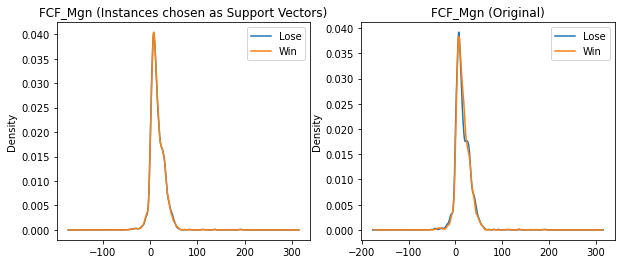

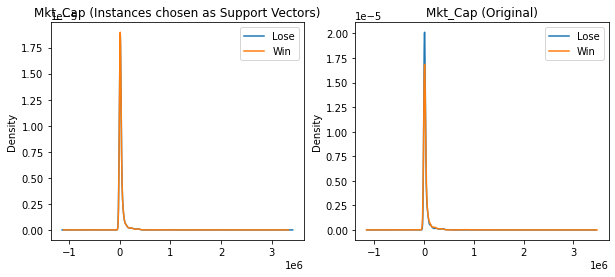

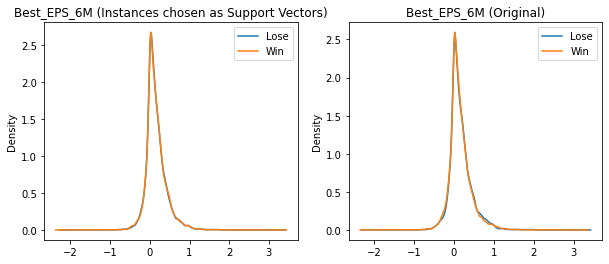

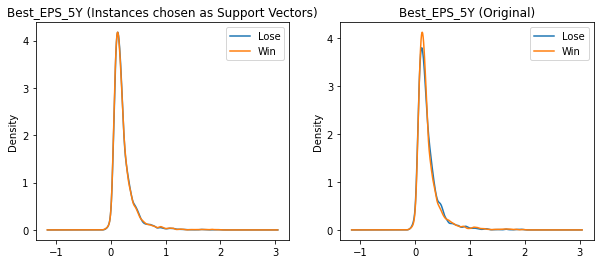

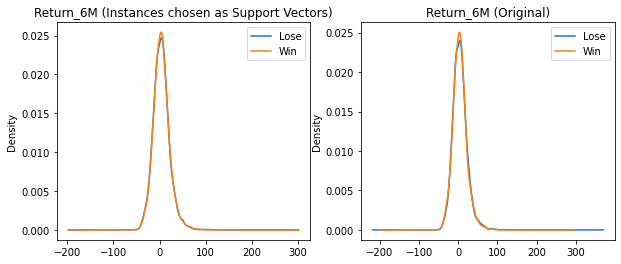

In [64]:
# now lets see the statistics of these attributes
from matplotlib import pyplot as plt
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Fwd_Return_3M_Class'])
df_grouped = X_imputed.groupby(['Fwd_Return_3M_Class'])

# plot KDE of Different variables
vars_to_plot = ['FCF_Mgn', 'Mkt_Cap', 'Best_EPS_6M', 'Best_EPS_5Y', 
               'Return_6M']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Lose','Win'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Lose','Win'])
    plt.title(v+' (Original)')


Using the graphs found above, and a few choice features, we can see how the support vectors compare to the original statistics of the data. There is not as much separation between the original distributions and the support vector distributions, which is initially odd. These graphs also show the relationships between the two and how they changed. It seems the support vecotrs tend to follow the original fairly closely, however, if the scale were to decrease between -5 and 5, we might see a very clear separation between the support vectors distribution and the original data distribution. The support vectors found on the edge of the original distributions are the instances on the edge of the class boundaries and that are incorrectly classified in the training data.